In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import _autolag
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import seaborn as sns
#sns.set_theme()
#from scipy.stats import pearsonr

DATA PREPARATION

In [51]:
data_df=pd.read_excel('Gas Data processed.xlsx',sheet_name="code_monthly_deflated_avg")
df=data_df.loc[15:140,["months", "price_gas", "price_brent_gbp","open_interest_gas","lng","storage","temperature","euas","supply","coal_gbp","eurgbp","gbpusd","churn","temp_deviation","price_range","price_gas_avg", "price_brent_usd","storage_dev","usd_gbp","share_lng"]] 
print(df)


#start at 15 for churn
#first ets value at line 38

     months  price_gas  price_brent_gbp  open_interest_gas       lng  \
15   Jan 11  61.175612        66.785907             28.710  2.430000   
16   Feb 11  58.253804        70.022260             22.565  1.990000   
17   Mar 11  65.671980        77.353399             19.575  2.460000   
18   Apr 11  63.693670        79.431267             16.590  2.680000   
19   May 11  61.265423        74.670881             19.680  2.480000   
..      ...        ...              ...                ...       ...   
136  Feb 21  40.967919        40.980074             41.235  1.897236   
137  Mar 21  40.658930        43.494060             44.325  2.321223   
138  Apr 21  46.712534        42.188306             37.515  2.111904   
139  May 21  57.411172        43.616761             35.298  1.428956   
140  Jun 21  64.147268        47.484969             35.409  1.016736   

      storage  temperature     euas     supply   coal_gbp   eurgbp    gbpusd  \
15   0.450000         5.10  17.7055  10.150000  81.9947

In [52]:
#Vector:
dprice_gas=df.price_gas
dprice_gas_avg=df.price_gas_avg
dprice_brent_gbp=df.price_brent_gbp
dprice_brent_usd=df.price_brent_usd
dOI=df.open_interest_gas
dtemp=df.temperature
dtempdev=df.temp_deviation
dstore=df.storage
dlng=df.lng
dshare_lng=df.share_lng
dsupply=df.supply
dEUAs=df.euas
dEUR=df.eurgbp
dGBPUSD=df.gbpusd
dcoal=df.coal_gbp
dchurn=df.churn
drange=df.price_range
dstoredev=df.storage_dev
dUSDGBP=df.usd_gbp


time= df.months
DataSeries=[dtempdev, dprice_brent_usd, dGBPUSD, dstore, dshare_lng, dchurn, dprice_gas_avg]
#DataSeries=[dprice_gas,dsupply, dlng, dstore, dtemp, dtempdev]

#DataSeries=[dprice_gas,dprice_brent_gbp,dOI,dstore,dlng,dtemp,dsupply,dEUAs,dchurn,dtempdev,dEUR,dUSD,dcoal]
df_test = pd.concat(DataSeries,axis=1)

In [53]:
######### INITIAL DATA TESTS #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary

from statsmodels.tsa.stattools import adfuller, kpss
######## NORMALITY TEST V2 ########

def normality_test_matrix(data, variables, test):    
    """Check normality test to comply with general model assumptions.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    test      : type of test to perform
    """

    col=['test statistic ','p-value ', 'lags used ']
    df = pd.DataFrame(np.zeros((len(variables), 3)), columns=col, index=variables)
    for r in df.index:
        if test == "Dickey-Fuller":
            dftestdickey = adfuller(data[r].values, autolag='AIC')
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestdickey[c]           
        elif test == "KPSS":
            dftestkpss = kpss(data[r].values, regression='c', nlags="auto")
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestkpss[c]

    print("Results for "+test+" test")
    df.columns = [var + test for var in col]

    #df.index = [var for var in variables]s
    return df


### styles ###

def highlight_cells_DF(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e < 0.05 else highlight_false for e in series]  

def highlight_cells_KPSS(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e > 0.05 else highlight_false for e in series]  


dfdifull = normality_test_matrix(df_test, variables = df_test.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)

Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
temp_deviation,-8.261315,0.000000,0.000000
price_brent_usd,-1.673331,0.444903,2.000000
gbpusd,-1.400337,0.582115,0.000000
storage,-2.882623,0.047406,11.000000
share_lng,-5.583949,0.000001,0.000000
churn,0.502259,0.984942,12.000000
price_gas_avg,-3.369024,0.012061,13.000000


In [54]:
dfkpss = normality_test_matrix(df_test, variables = df_test.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range

,test statistic KPSS,p-value KPSS,lags used KPSS
temp_deviation,0.310280,0.100000,3.000000
price_brent_usd,1.372267,0.010000,6.000000
gbpusd,1.497526,0.010000,6.000000
storage,0.224000,0.100000,5.000000
share_lng,0.362846,0.093170,5.000000
churn,0.631648,0.019759,5.000000
price_gas_avg,0.666585,0.016583,6.000000


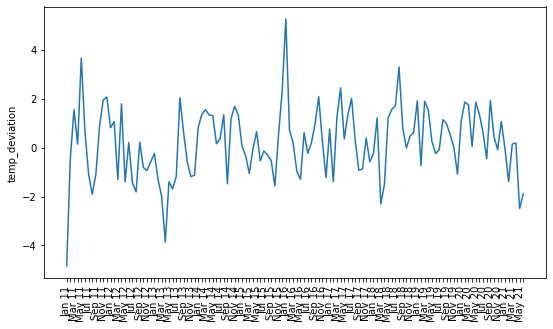

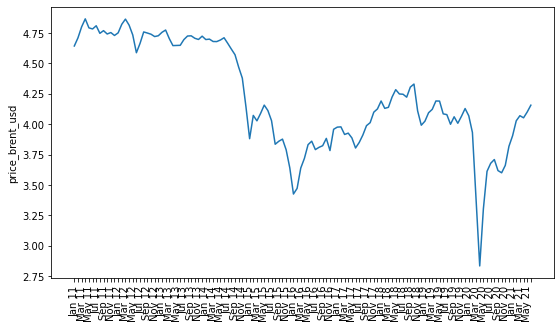

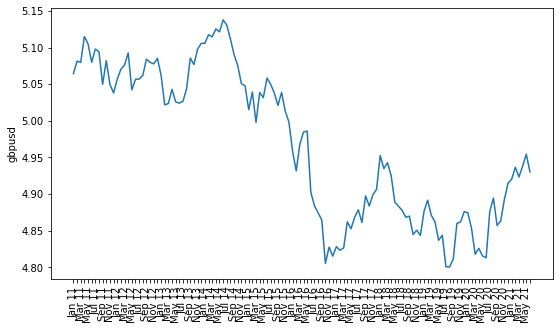

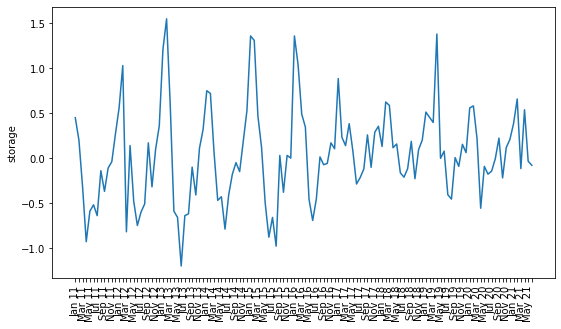

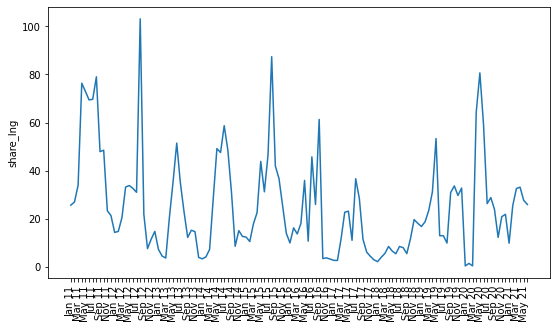

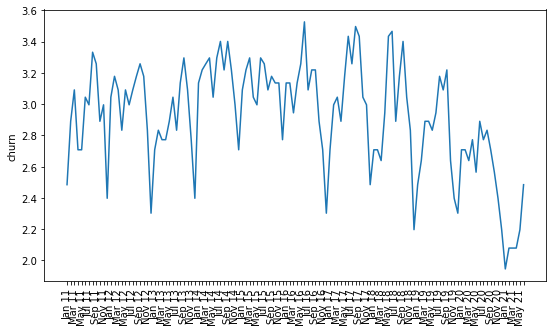

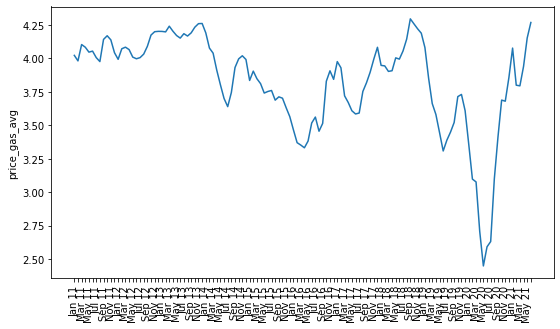

In [55]:
######### DATA CORRECTION #########
#ideally, for each set, apply specific changes
# detrending for linear processes
# differences for random walks 
# other ? non linear processes

#### initiate corrected series
DataSeriesCorr=[]

#### select correction mode
TypeCorr = 'mixed' # 'HP' for filtering or 'log' or 'bothHPlog'

HP =[]#['churn','usd_gbp']
loga = ['price_brent_usd','price_gas_avg','churn','gbpusd']

for df in DataSeries:

    if TypeCorr == "log" or TypeCorr == 'bothHPlog' or TypeCorr == 'mixed':
            if df.name in loga:
                df_log = pd.Series(np.log(df))
                df = df_log

    if TypeCorr == 'HP' or TypeCorr == 'bothHPlog' or TypeCorr == 'mixed':
        if df.name in HP or TypeCorr == 'HP':
            cycle, trend = sm.tsa.filters.hpfilter(df, 129600)
            plt.plot(trend)
            plt.plot(cycle)
            cycle.name = df.name
            trans = cycle/trend
            plt.plot(trans)
            trans.name = df.name
            df = trans
            

    if TypeCorr == 'diff':
        df_diff = df.diff().dropna()
        df = df_diff

    plt.figure(figsize=(9, 5))
    if TypeCorr == 'diff':        
        plt.plot(time.iloc[1:], df)
    else: 
        plt.plot(time, df)
    plt.ylabel(df.name)
    ax = plt.gca()
    plt.xticks(rotation=90)
    for label in ax.get_xaxis().get_ticklabels()[1::2]:
        label.set_visible(False)
    plt.show()
    DataSeriesCorr.append(df)

df_corr = pd.concat(DataSeriesCorr,axis=1)




TRUNCATE DATASET

In [ ]:
15:140

In [56]:
######### STATIONARITY DATA TEST #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary


dfdifull = normality_test_matrix(df_corr, variables = df_corr.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)


Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
temp_deviation,-8.261315,0.000000,0.000000
price_brent_usd,-1.834052,0.363691,2.000000
gbpusd,-1.418596,0.573329,0.000000
storage,-2.882623,0.047406,11.000000
share_lng,-5.583949,0.000001,0.000000
churn,1.118593,0.995372,12.000000
price_gas_avg,-3.039121,0.031399,10.000000


In [57]:
dfkpss = normality_test_matrix(df_corr, variables = df_corr.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range

,test statistic KPSS,p-value KPSS,lags used KPSS
temp_deviation,0.310280,0.100000,3.000000
price_brent_usd,1.252271,0.010000,6.000000
gbpusd,1.490339,0.010000,6.000000
storage,0.224000,0.100000,5.000000
share_lng,0.362846,0.093170,5.000000
churn,0.717939,0.011915,5.000000
price_gas_avg,0.657442,0.017414,6.000000


In [58]:
#### EXPORT NORMALISED DATA ####


df_export = df_corr

#df_export.insert(0,'months',time)
#print(df_export)
#df_export.to_excel(r'export_normal_data.xlsx', index = False)

#df_corr.drop(columns=['months'])
#print(df_corr)

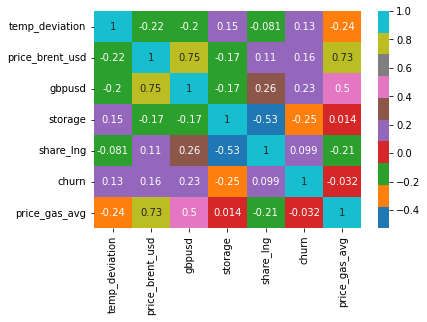

In [59]:
#### CORRELATION MATRIX ####

CorrelationMatrix=df_corr.corr()
ax=sns.heatmap(CorrelationMatrix, annot=True, cmap="tab10")


     temp_deviation  price_brent_usd    gbpusd   storage  share_lng     churn  \
15        -4.838333         4.643241  5.064448  0.450000   25.60590  2.484907   
16        -0.440000         4.710267  5.081434  0.200000   26.89189  2.890372   
17         1.546667         4.800665  5.079793 -0.320000   33.88430  3.091042   
18         0.138333         4.866745  5.114997 -0.930000   76.35328  2.708050   
19         3.653333         4.792601  5.105204 -0.590000   72.94118  2.708050   
..              ...              ...       ...       ...        ...       ...   
136       -1.390000         4.027565  4.936630  0.658246   25.39336  2.079442   
137        0.146667         4.069541  4.923380 -0.116558   32.50912  2.079442   
138        0.188333         4.052141  4.938268  0.538452   33.08184  2.079442   
139       -2.496667         4.099967  4.954444 -0.034491   27.59053  2.197225   
140       -1.893333         4.156097  4.930347 -0.079826   25.89032  2.484907   

     price_gas_avg  
15    

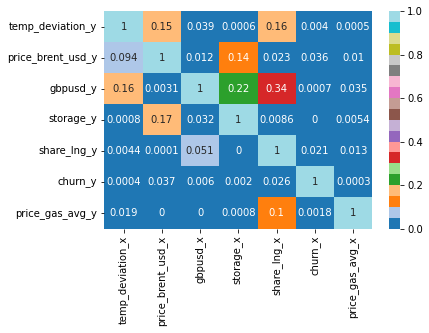

In [60]:
#### CORRECTED GRANGER CAUSALITY ####

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=15
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    #plot
    sns.heatmap(df, annot=True, cmap="tab20")
    #return df


##### actual test
print(df_corr)
grangers_causation_matrix(df_corr, variables = df_corr.columns)        


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


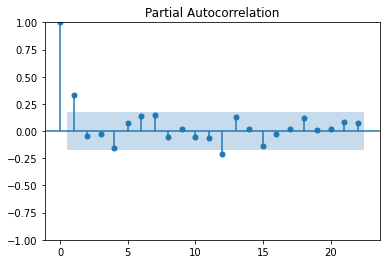

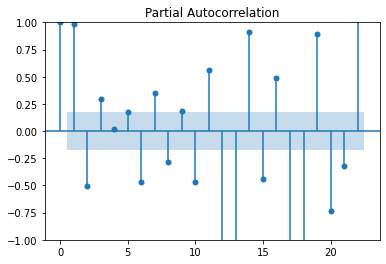

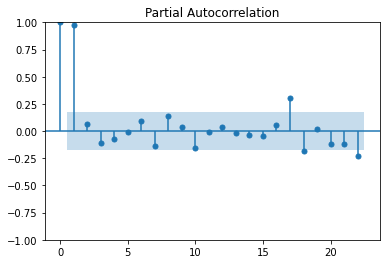

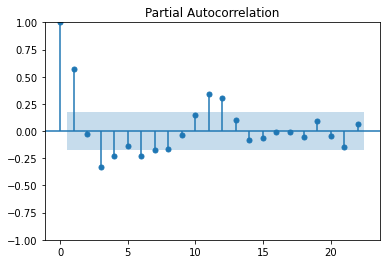

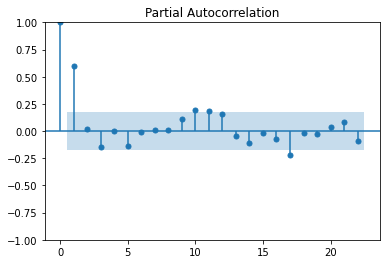

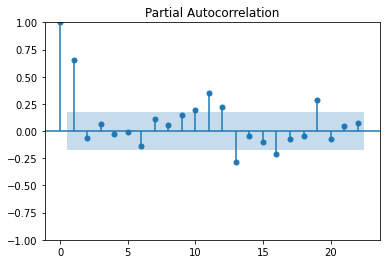

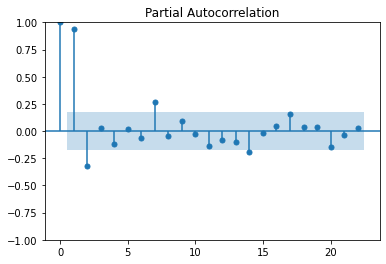

In [61]:
######### LAG LENGTH CRITERIA ######### either multiple of frequency or Schwarz, akaike, hannan-quinn, bayesian 

for df in DataSeries:
    plot_pacf(df)
    plt.show()

# for df in DataSeries:
#     lag_selection = _autolag(mod=VAR,endog=df, exog=df, startlag=1, maxlag=30, method="aic")
#     lag_selection.results()
#     #plt.show()


In [62]:
##### MODEL FITTING #####

model = VAR(df_corr)
x = model.select_order()
x.summary()
#model_fit = model.fit(maxlags=10, ic="aic") #aic, or bic
#model_fit.summary()


#model_fit.plot()


,AIC,BIC,FPE,HQIC
0,-7.596,-7.428,0.0005022,-7.528
1,-14.86,-13.50*,3.539e-07,-14.31*
2,-14.91,-12.38,3.379e-07,-13.88
3,-14.99,-11.27,3.203e-07,-13.48
4,-15.26,-10.36,2.566e-07,-13.27
5,-15.08,-9.002,3.303e-07,-12.62
6,-14.96,-7.696,4.219e-07,-12.01
7,-14.70,-6.249,6.563e-07,-11.27
8,-14.84,-5.208,7.326e-07,-10.93
9,-14.82,-4.011,1.055e-06,-10.44


In [63]:
##### MODEL FITTING BASED ON LAG CRITERIA RESULTS ######

lag_order =4
model_fit = model.fit(6)
model_fit.summary()

#model_fit.plot()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 23, Aug, 2022
Time:                     23:08:01
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -7.98657
Nobs:                     120.000    HQIC:                  -12.1391
Log likelihood:           7.80347    FPE:                3.94525e-07
AIC:                     -14.9785    Det(Omega_mle):     4.62413e-08
--------------------------------------------------------------------
Results for equation temp_deviation
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     10.615302         8.962974            1.184           0.236
L1.temp_deviation          0.364006         0.117899            3.087           0.002
L1.price_brent_usd         1.73

True


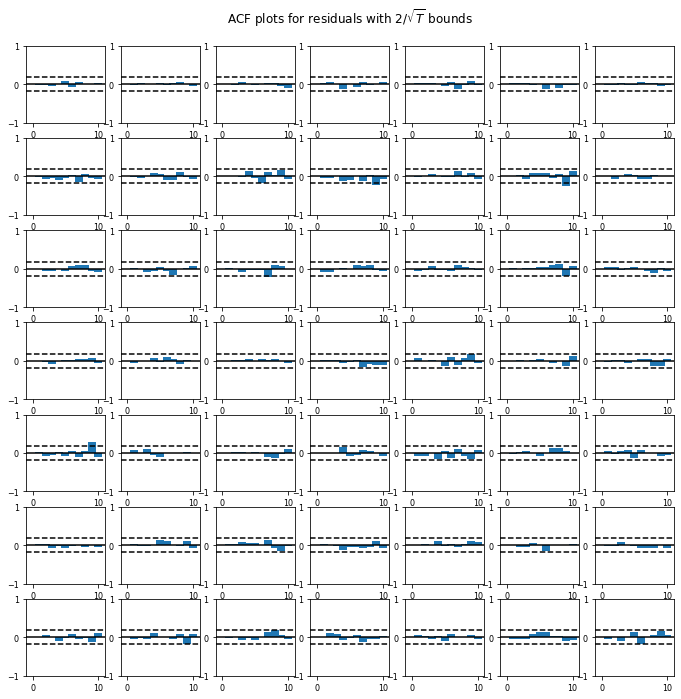

In [64]:
######### STABILITY RESIDUALS AUTOCORRELATION #########
accor = model_fit.plot_acorr()

stab = model_fit.is_stable()
print(stab)

#if residuals out of range -> unstable model 

In [65]:
######### GRANGER CAUSALITY TEST #########
#for gas price
#GrangerCausality = model_fit.test_causality('price_gas', ['lng'], kind='f')
#print(GrangerCausality.summary())

#granger causality test : HO not rejected => there is some causality between the variables

#importance of the order: if p value higher, does it mean that one variable is generating the other ?

In [66]:
######### NORMALITY TEST #########

TestNorm = model_fit.test_normality()
print(TestNorm.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         79.24          23.68   0.000 14
----------------------------------------


In [67]:
######### Whiteness TEST ######### (absence of significant residual autocorrelations)

TestWhite = model_fit.test_whiteness(nlags=18)
print(TestWhite.summary())

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 18 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         642.2          645.5   0.060 588
-----------------------------------------


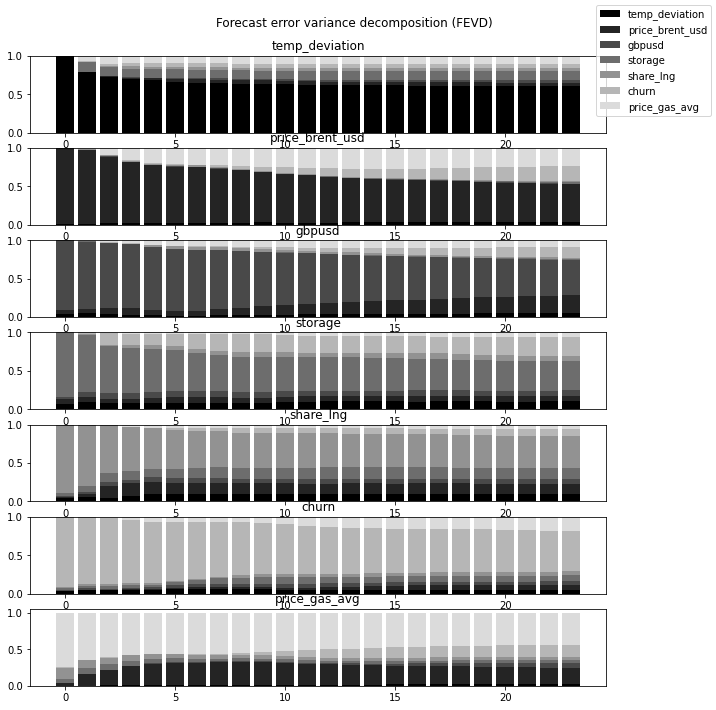

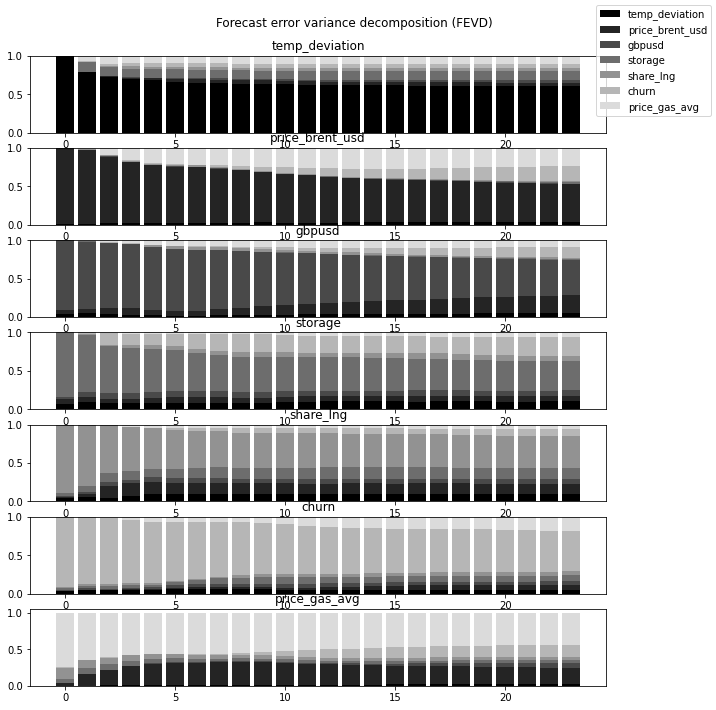

In [68]:
######### FORECAST VARIANCE ERROR DECOMPOSITION: #########

#only for 20 periods
n=24
VD = model_fit.fevd(n)
#fevd.summary()

#affichage pour n périodes
VD.plot()

IMPULSE RESPONSE ANALYSIS:

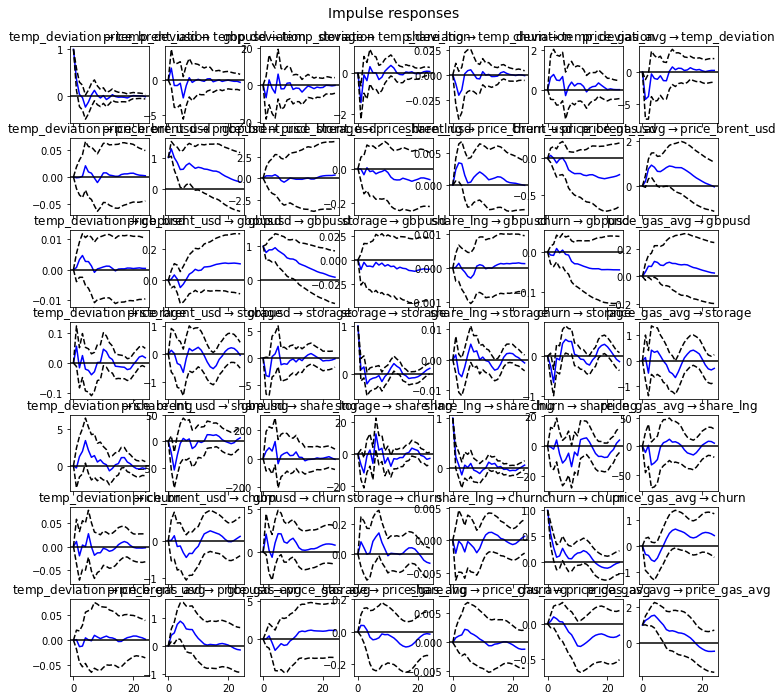

In [69]:
Impulse = model_fit.irf(24)

Impulse.plot()

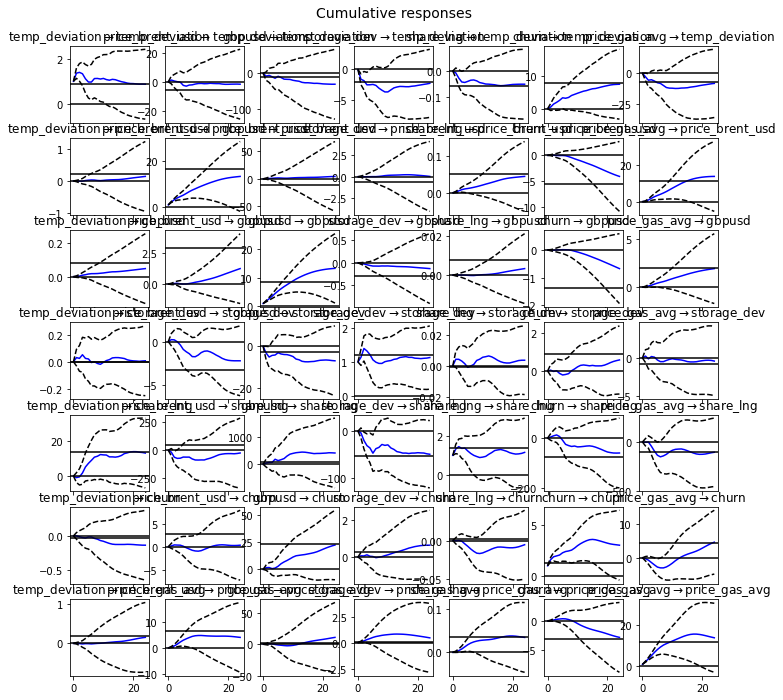

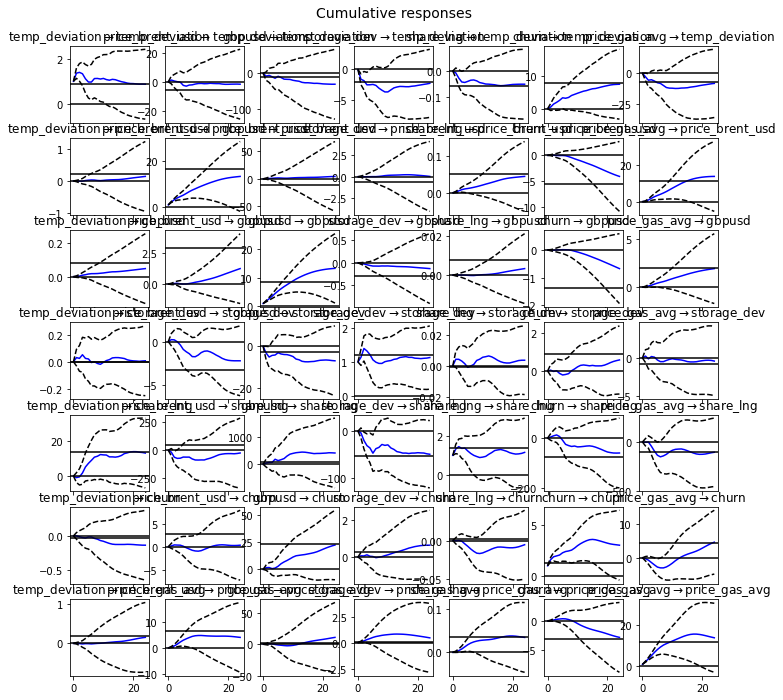

In [ ]:
Impulse.plot_cum_effects(orth=False)

OTHER MODELS

In [ ]:
from statsmodels.tsa.api import SVAR
 
lag_order = 7

#A = np.asarray([['E',0,0,0,0,0,0], [0,'E','E',0,0,0,0],[0,'E','E',0,0,0,0],['E',0,0,'E','E',0,'E'],['E',0,'E','E','E',0,'E'],['E','E','E','E','E','E','E'],['E','E','E','E','E',0,'E']])
#A = np.asarray([['E', 0, 0, 0, 0, 0, 0], [0, 'E', 0, 0, 0, 0, 0],[0, 0, 'E', 0, 0, 0, 0],[0, 0, 0, 'E', 0, 0, 'E'],[0, 0, 0, 0, 'E', 0, 'E'],['E', 'E', 'E', 'E', 'E', 'E', 'E'],['E', 'E', 'E', 'E', 'E', 0, 'E']])
A = np.asarray([['E', 0, 0, 0, 0, 0, 0], ['E', 'E', 0, 0, 0, 0, 0],['E', 'E', 'E', 0, 0, 0, 0],['E', 'E', 0, 'E', 0, 0, 'E'],['E', 'E', 0, 'E', 'E', 0, 'E'],['E', 'E', 'E', 'E', 'E', 'E', 0],['E', 'E', 'E', 'E', 'E', 'E', 'E']])
#A = np.asarray([['E', 0, 0, 0, 0, 0, 0], [0, 'E', 0, 0, 0, 0, 0],[0, 0, 'E', 0, 0, 0, 0],[0, 0, 0, 'E', 0, 0, 0],[0, 0, 0, 0, 'E', 0, 0],[0, 0, 0, 0, 0, 'E', 0],['E', 'E', 'E', 'E', 'E', 'E', 'E']]) 


StructModel = SVAR(df_corr,svar_type='A', A=A)

#dtempdev, dstore, dlng, dprice_brent_gbp, drange

ResSVAR = StructModel.fit(maxlags=lag_order, maxiter=10000, maxfun=10000, solver='bfgs')



/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
##### IS STABLE ? #####
Stab = ResSVAR.is_stable()
print("SVAR model is stable ? :   ",Stab)


SVAR model is stable ? :    True


In [ ]:
######### Whiteness TEST ######### (absence of significant residual autocorrelations)

#TestWhite = ResSVAR.test_whiteness(nlags=12)
#print(TestWhite.summary())

TestWhite = ResSVAR.test_whiteness(nlags=24)
print(TestWhite.summary())  

#Portmanteau test

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 24 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         857.1          901.3   0.274 833
-----------------------------------------


In [ ]:
######### NORMALITY TEST #########

TestNorm = ResSVAR.test_normality()
print(TestNorm.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         60.22          23.68   0.000 14
----------------------------------------


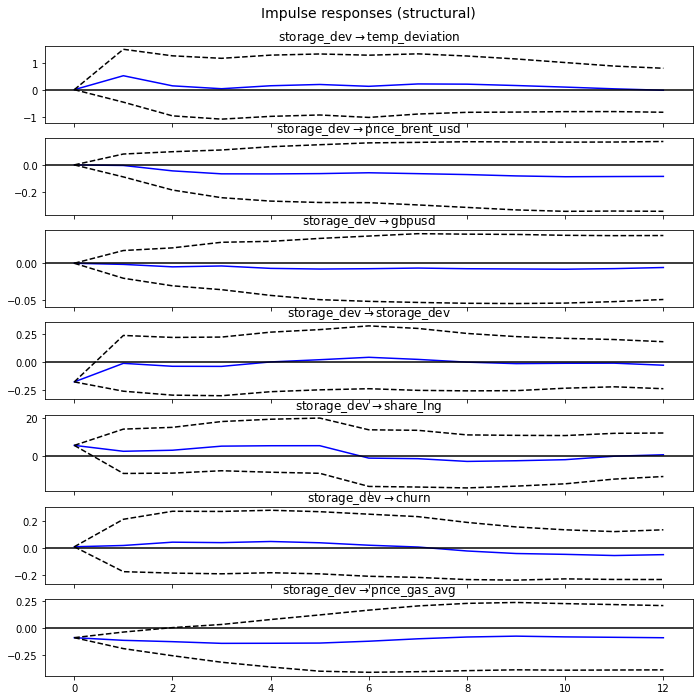

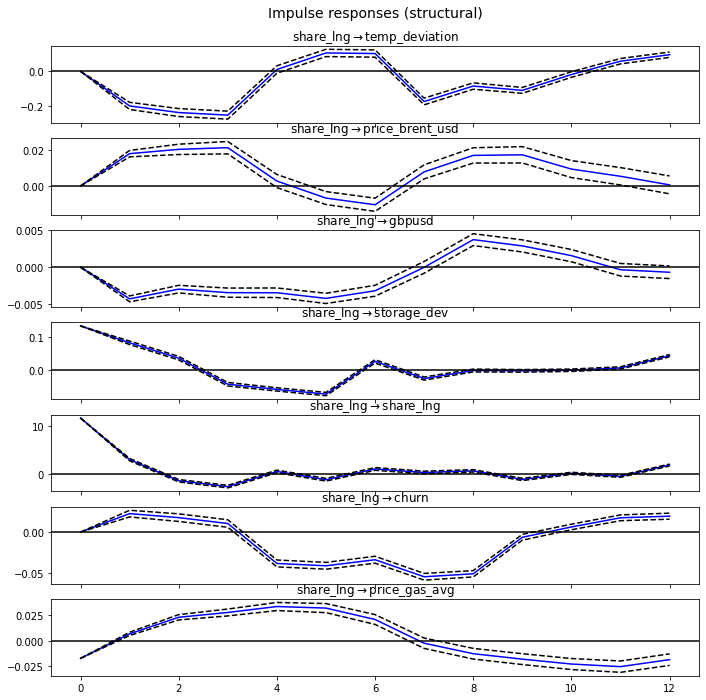

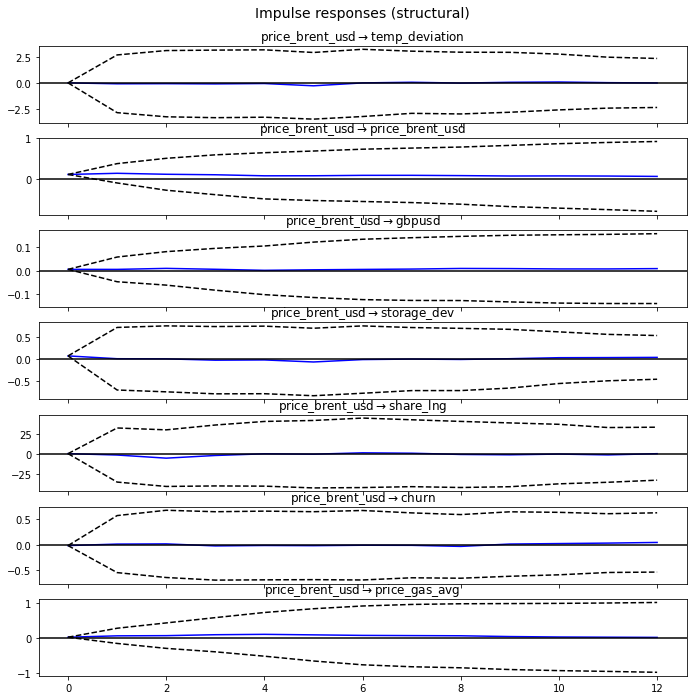

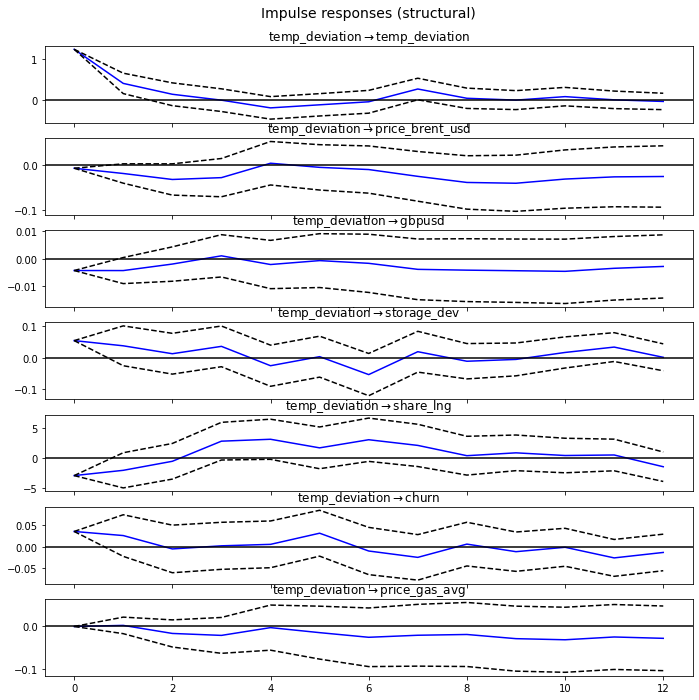

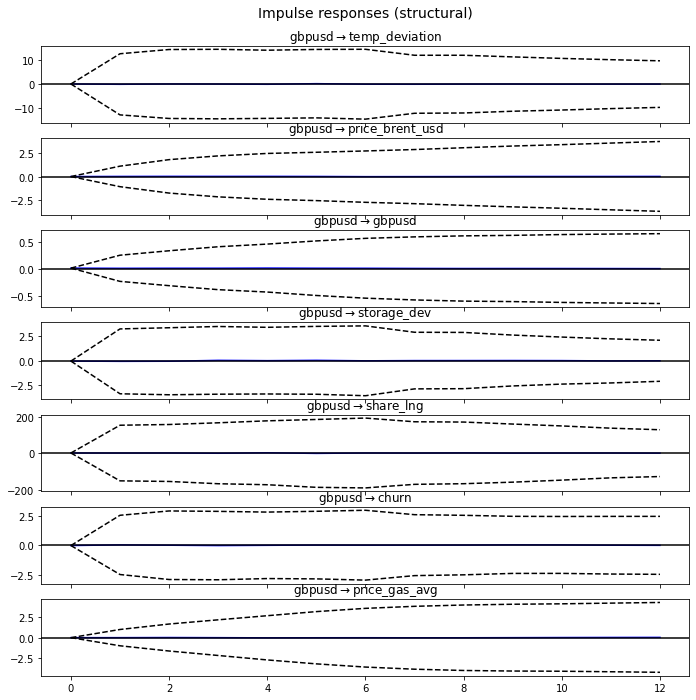

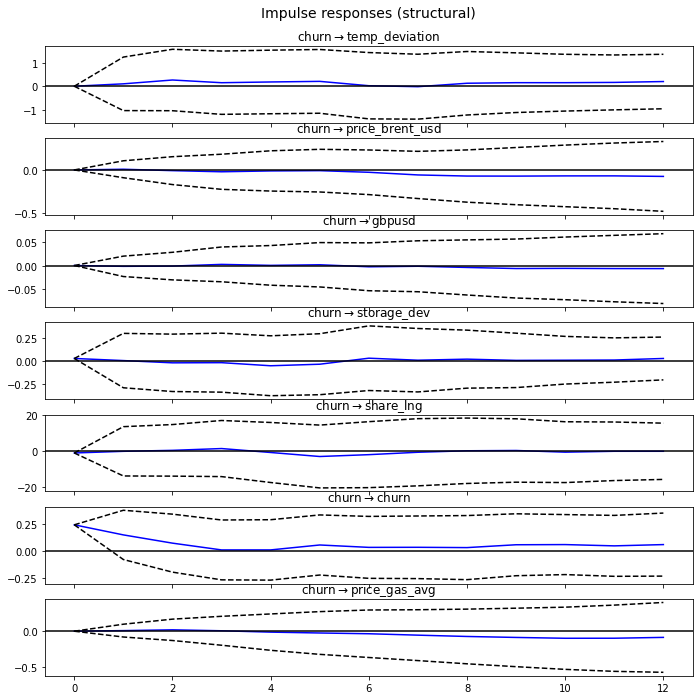

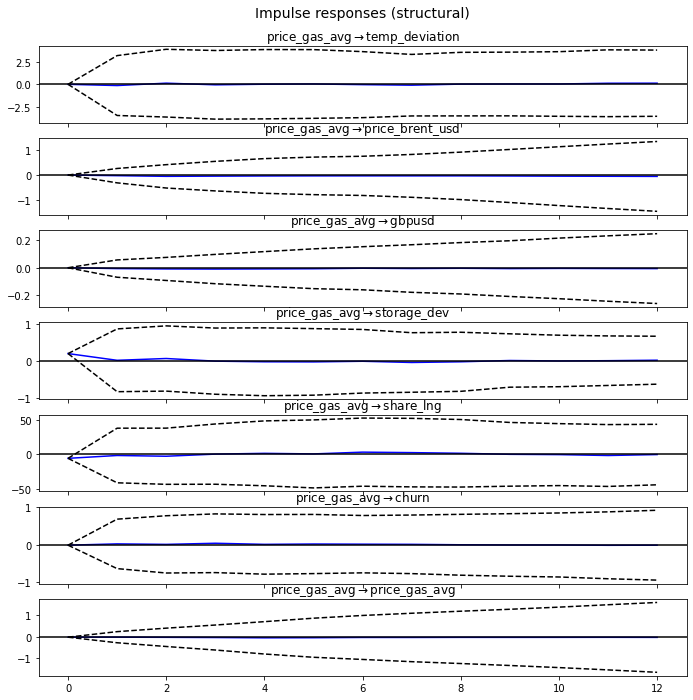

In [ ]:
#### IR ####


ResSVAR.irf(periods=12).plot(impulse='storage')
ResSVAR.irf(periods=12).plot(impulse='share_lng')
ResSVAR.irf(periods=12).plot(impulse='price_brent_usd')
ResSVAR.irf(periods=12).plot(impulse='temp_deviation')
ResSVAR.irf(periods=12).plot(impulse='gbpusd')
ResSVAR.irf(periods=12).plot(impulse='churn')
ResSVAR.irf(periods=12).plot(impulse='price_gas_avg')

ResSVAR.irf()


#ResSVAR.irf(periods=12).plot(impulse='price_gas_avg', plot_stderr=True,stderr_type='asym', repl=100)



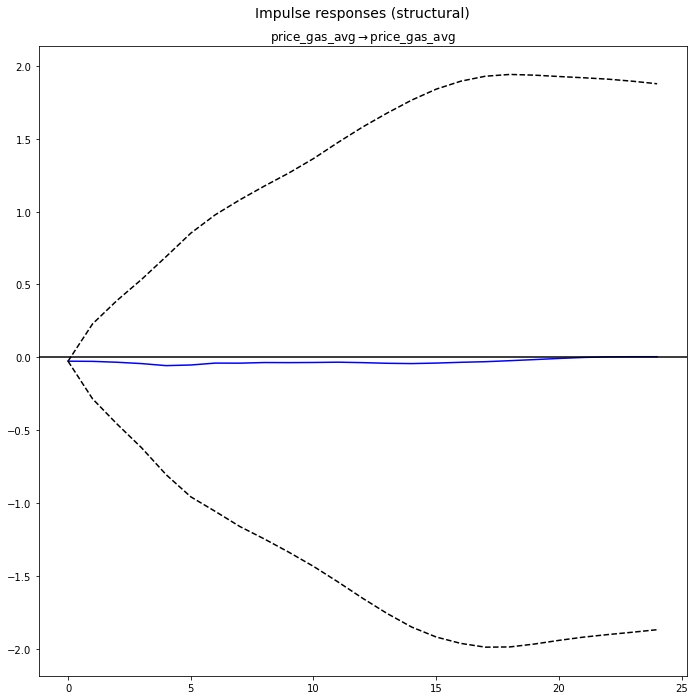

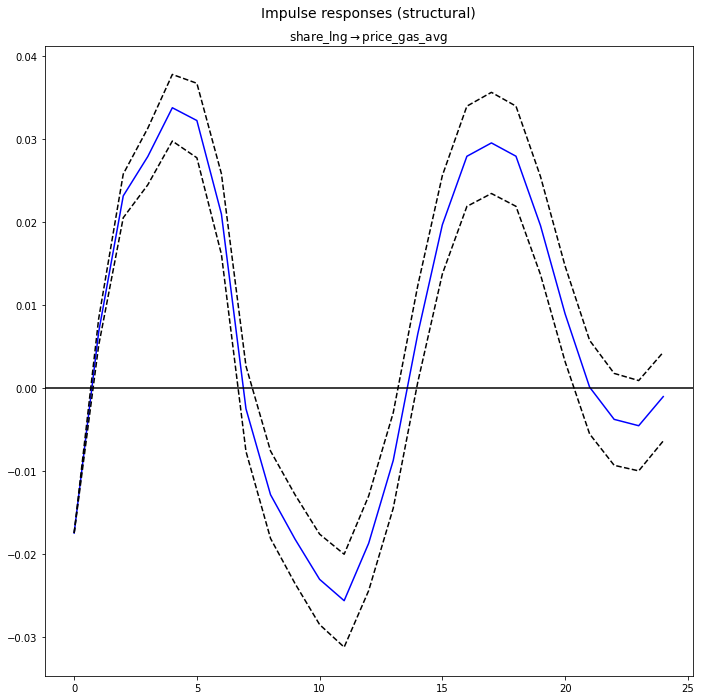

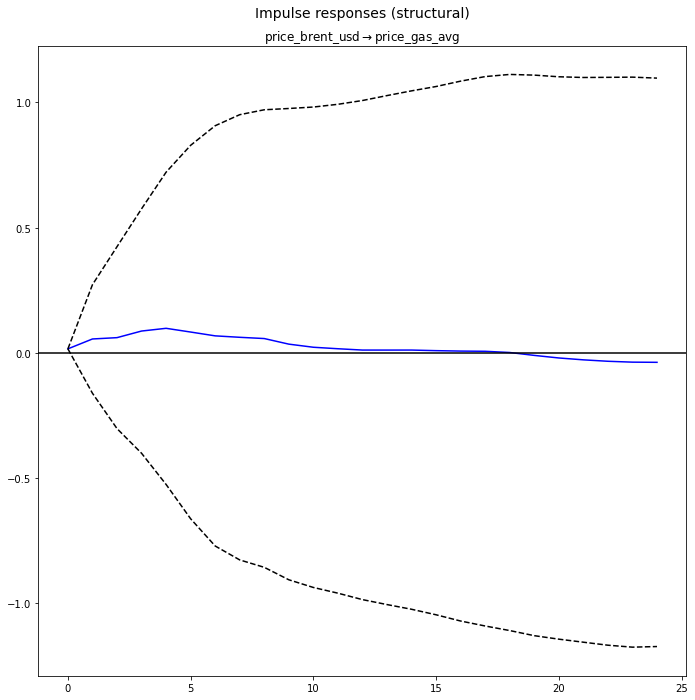

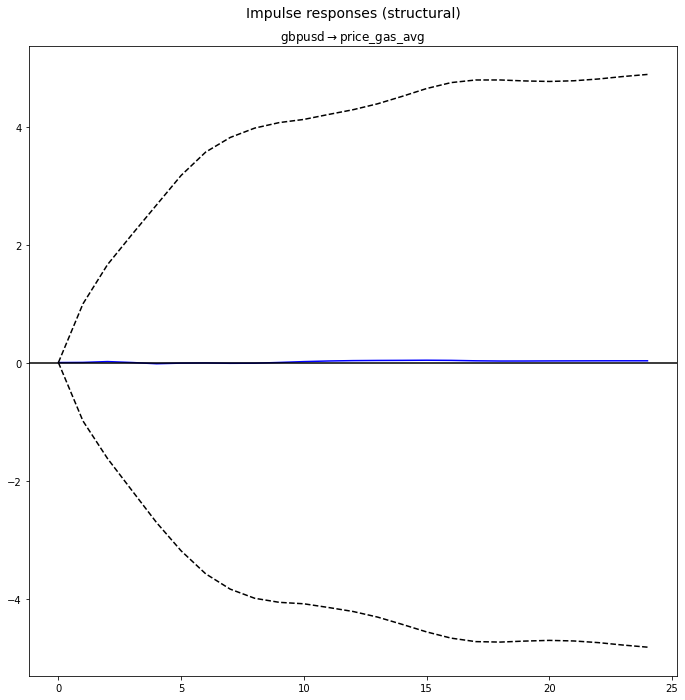

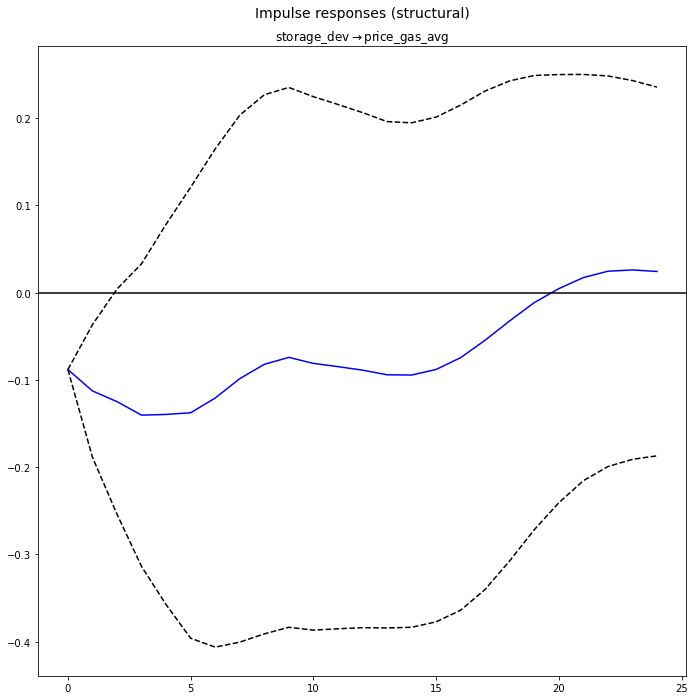

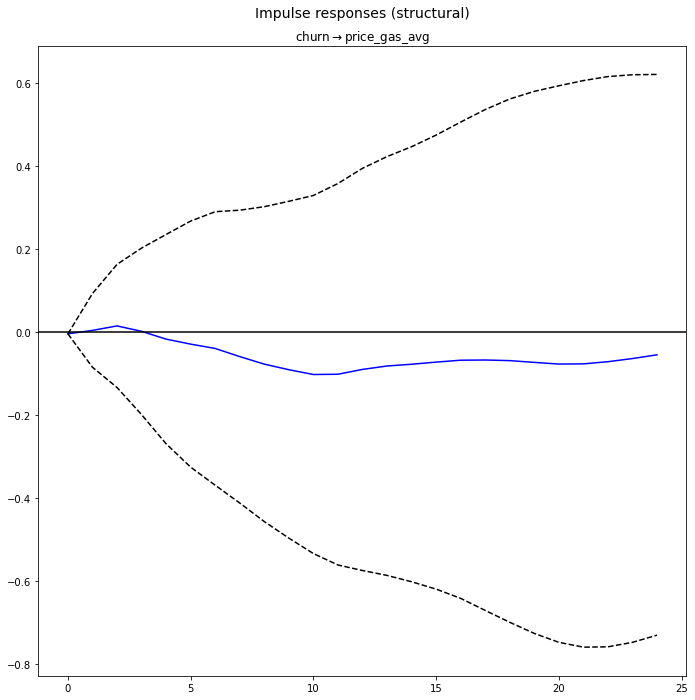

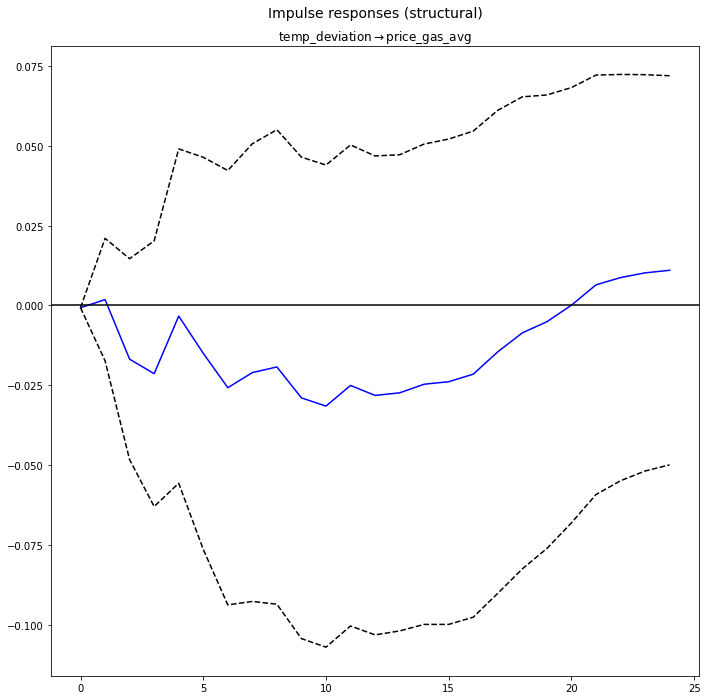

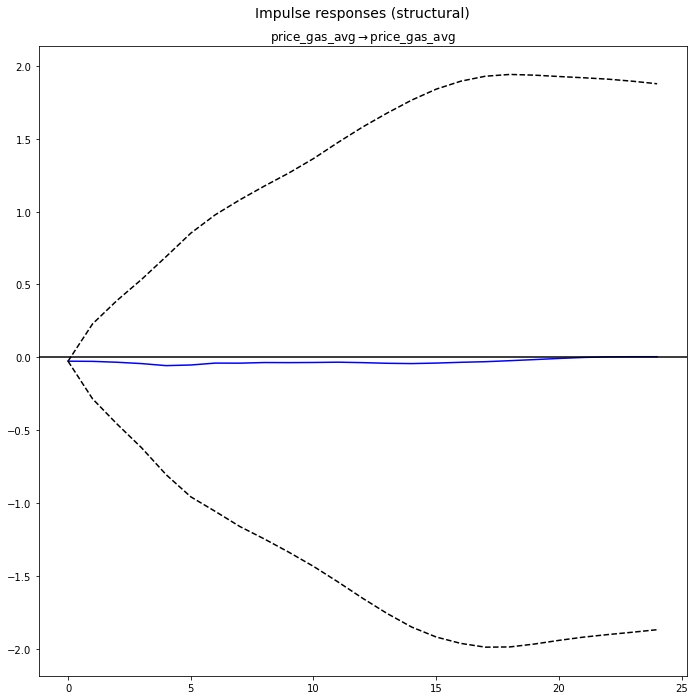

In [ ]:
### IR ###

Periods=24
Reps=500
ERRORTYPE = 'asym'

ResSVAR.irf(periods=Periods).plot(impulse='share_lng', response='price_gas_avg', plot_stderr=True,stderr_type=ERRORTYPE, repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse='price_brent_usd', response='price_gas_avg', plot_stderr=True,stderr_type=ERRORTYPE, repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse='gbpusd', response='price_gas_avg', plot_stderr=True,stderr_type=ERRORTYPE, repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse='storage', response='price_gas_avg', plot_stderr=True,stderr_type=ERRORTYPE, repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse='churn', response='price_gas_avg', plot_stderr=True,stderr_type=ERRORTYPE, repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse='temp_deviation', response='price_gas_avg', plot_stderr=True,stderr_type=ERRORTYPE, repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse='price_gas_avg', response='price_gas_avg', plot_stderr=True,stderr_type=ERRORTYPE, repl=Reps)


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Pyt

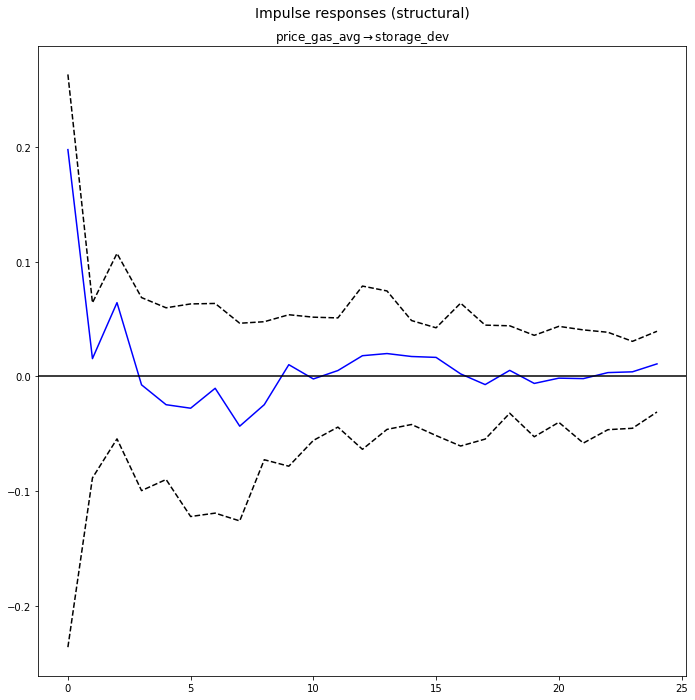

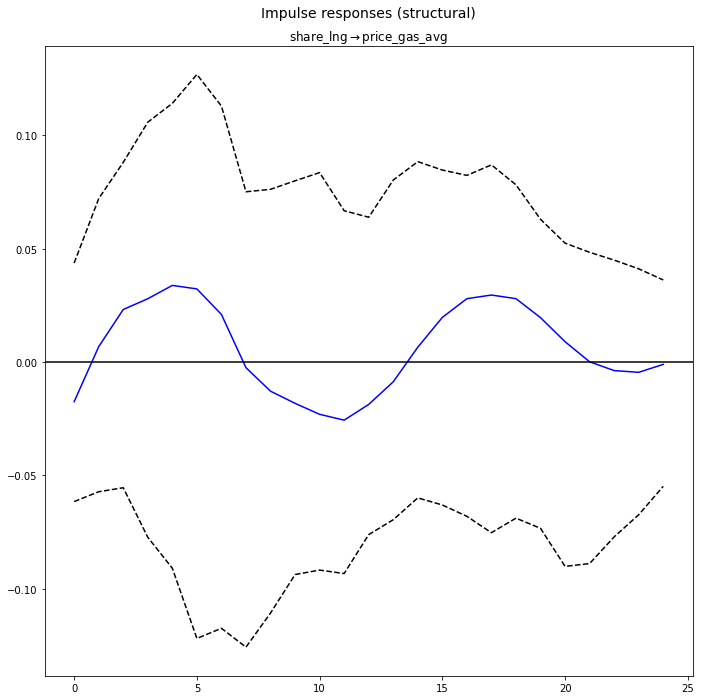

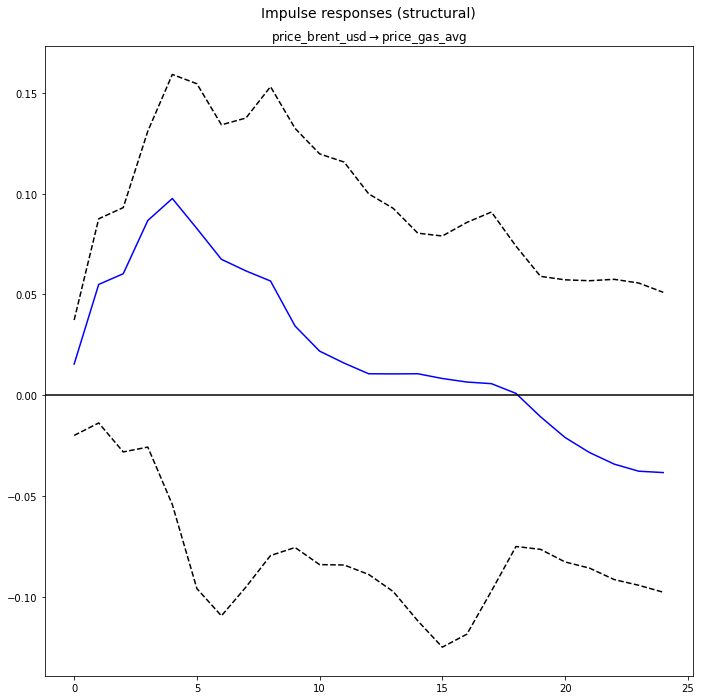

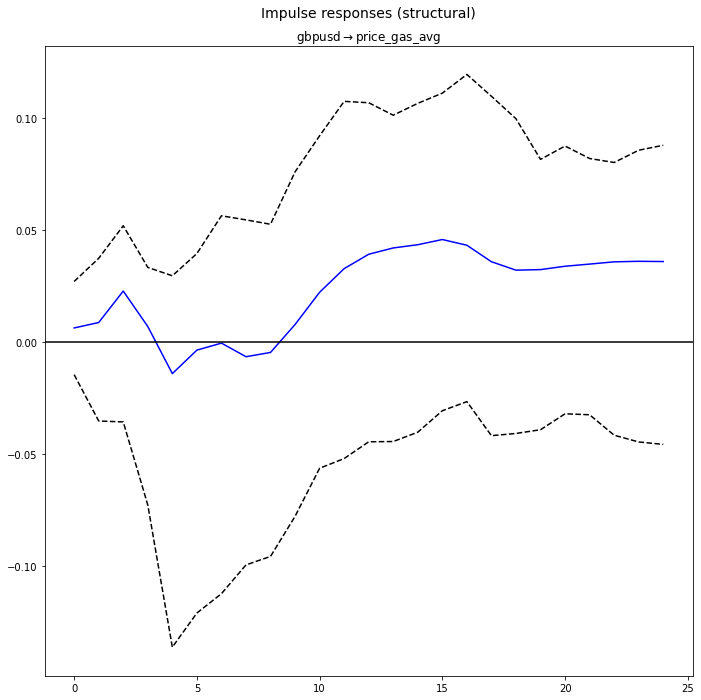

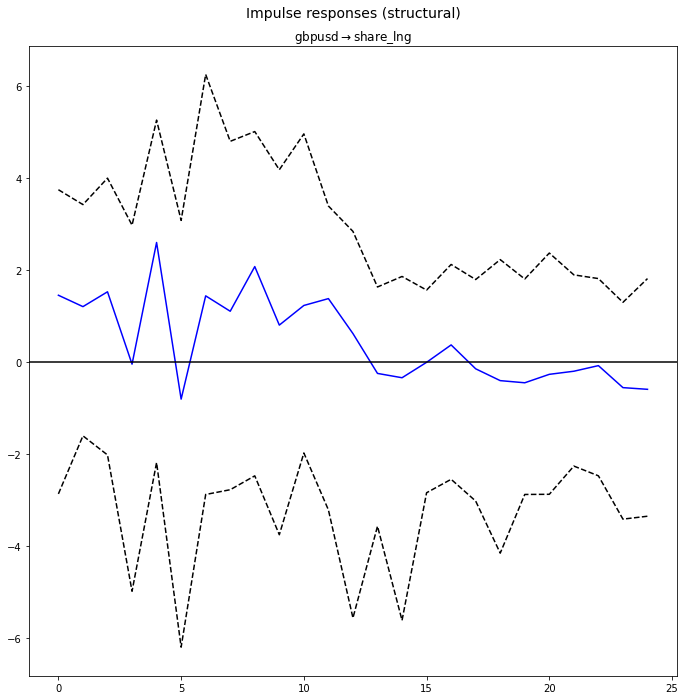

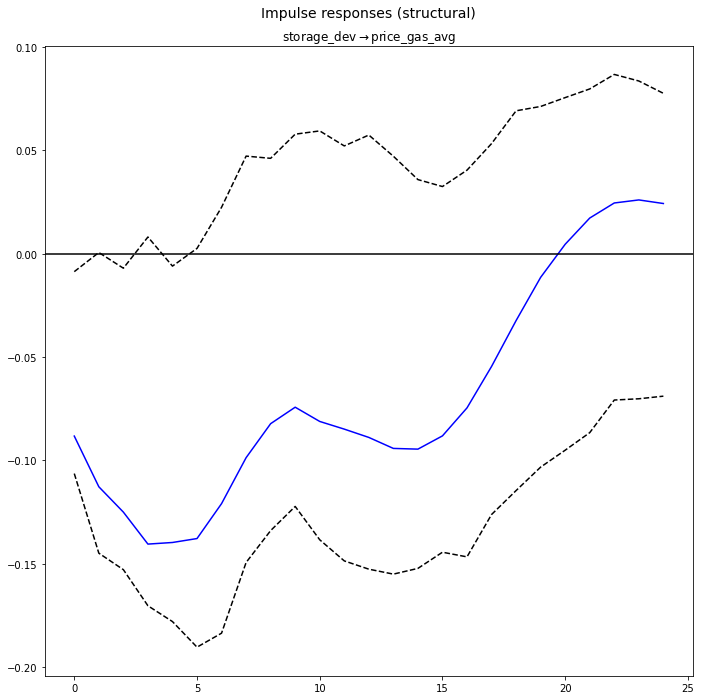

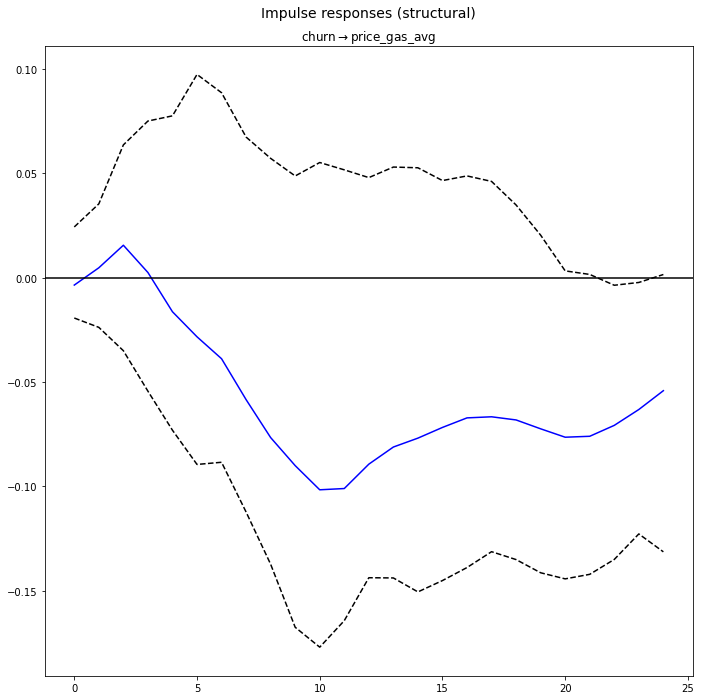

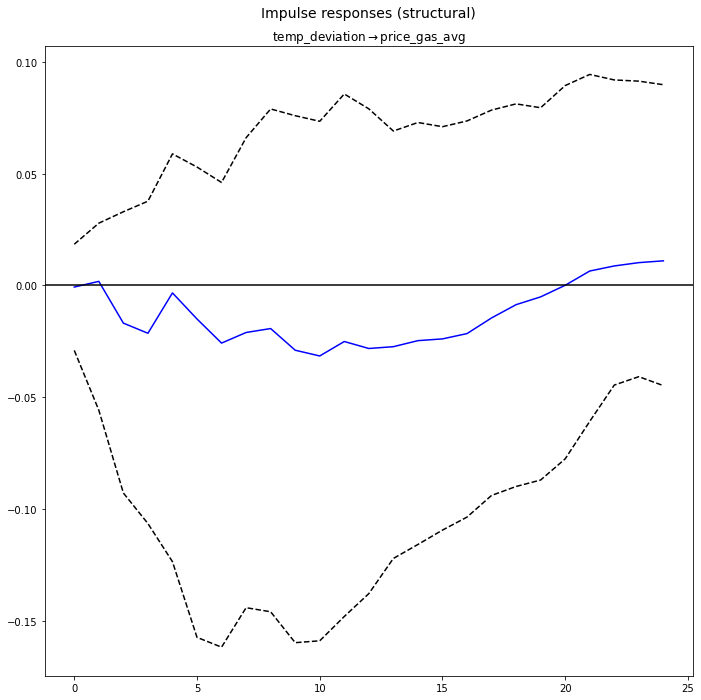

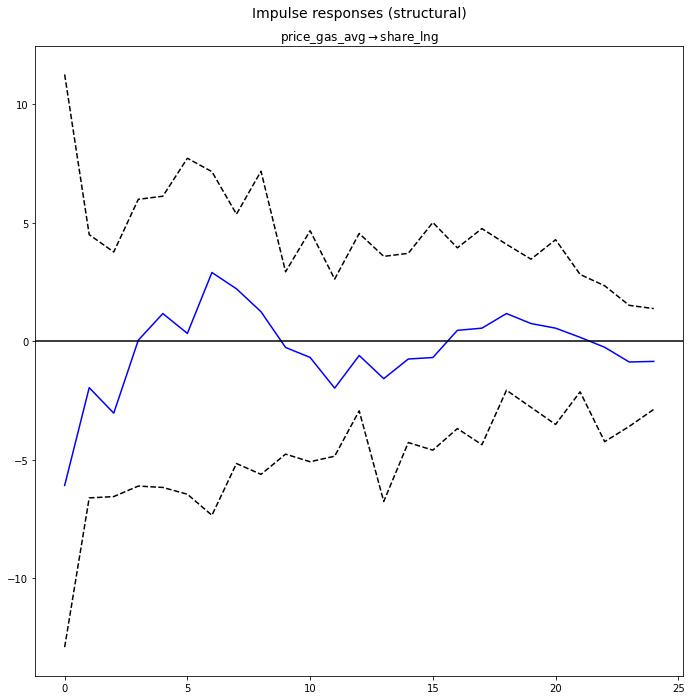

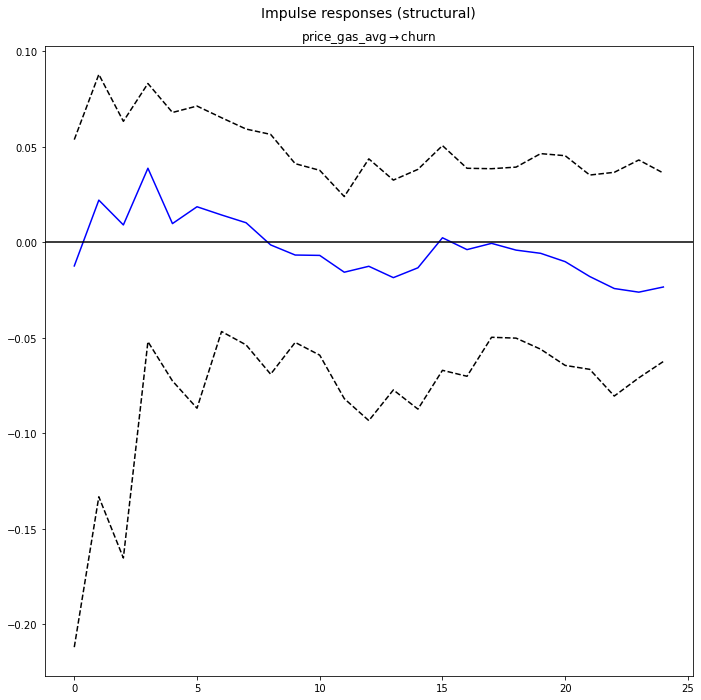

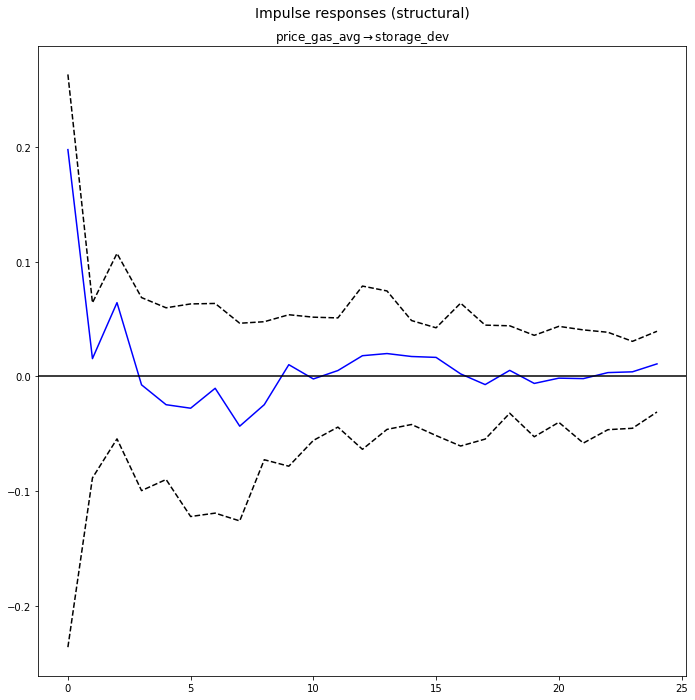

In [ ]:
### IR ###

Periods=24
Reps=50

ResSVAR.irf(periods=Periods).plot(impulse='share_lng', response='price_gas_avg', plot_stderr=True,stderr_type='mc', repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse='price_brent_usd', response='price_gas_avg', plot_stderr=True,stderr_type='mc', repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse='gbpusd', response='price_gas_avg', plot_stderr=True,stderr_type='mc', repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse='gbpusd', response='share_lng', plot_stderr=True,stderr_type='mc', repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse='storage', response='price_gas_avg', plot_stderr=True,stderr_type='mc', repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse='churn', response='price_gas_avg', plot_stderr=True,stderr_type='mc', repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse='temp_deviation', response='price_gas_avg', plot_stderr=True,stderr_type='mc', repl=Reps)



ResSVAR.irf(periods=Periods).plot(impulse='price_gas_avg', response='share_lng', plot_stderr=True,stderr_type='mc', repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse='price_gas_avg', response='churn', plot_stderr=True,stderr_type='mc', repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse='price_gas_avg', response='storage', plot_stderr=True,stderr_type='mc', repl=Reps)


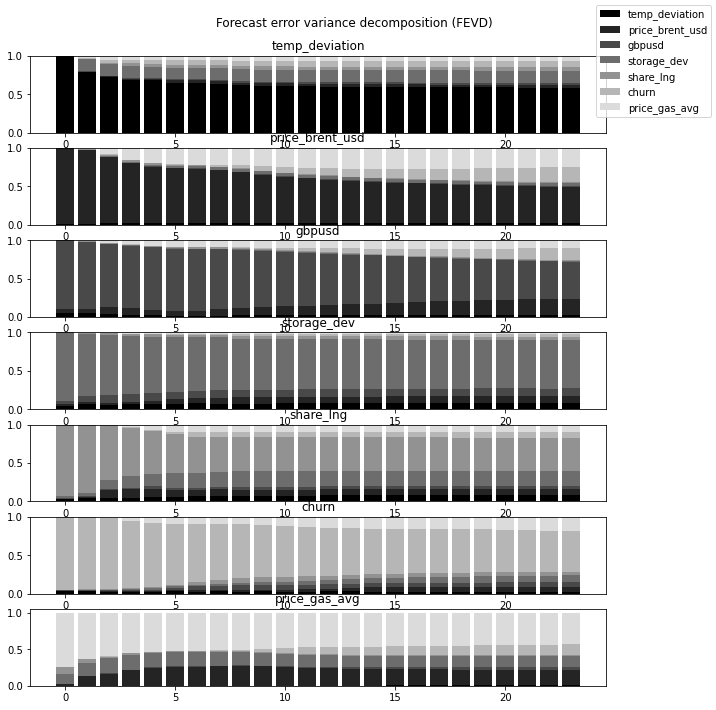

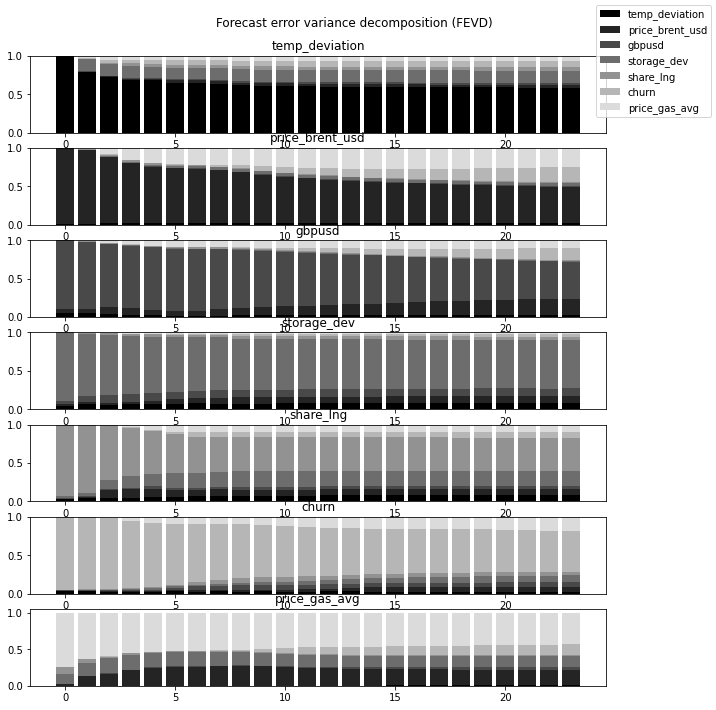

In [ ]:
#### FEVD ####


#only for 20 periods
n=24
fevd = model_fit.fevd(n)
#fevd.summary()

#affichage pour n périodes
model_fit.fevd(n).plot()

In [ ]:
#print(dir(fevd))
#print(fevd.decomp)

index = 5

gas = fevd.decomp[5]

res = []
for i in range(0,len(gas)):
    sub=[]
    for y in gas[i]:
        sub.append(y*100)
    #print(i)
    #print(sub)
    res.append(sub)
    
fevd.summary()



FEVD for temp_deviation
      temp_deviation  price_brent_usd    gbpusd  storage_dev  share_lng     churn  price_gas_avg
0           1.000000         0.000000  0.000000     0.000000   0.000000  0.000000       0.000000
1           0.792049         0.001313  0.005081     0.162075   0.000180  0.009837       0.029465
2           0.726081         0.008373  0.004701     0.152352   0.020277  0.035821       0.052395
3           0.691355         0.012520  0.006948     0.154674   0.042948  0.041103       0.050453
4           0.681938         0.014867  0.011917     0.148674   0.041255  0.049605       0.051744
5           0.650963         0.034737  0.015645     0.140155   0.042070  0.062316       0.054114
6           0.643474         0.037765  0.017124     0.141050   0.044328  0.061971       0.054287
7           0.630282         0.036324  0.018902     0.149574   0.044046  0.061411       0.059462
8           0.614982         0.035949  0.018476     0.153233   0.042988  0.069110       0.065262
9     

[[ 1.06833333  3.81745181  4.91490676 -0.13       21.78233     2.19722458
   3.8589537 ]
 [-0.03833333  3.90452666  4.92041952 -0.39        9.749675    1.94591015
   4.07711363]
 [-1.39        4.02756495  4.93662988 -0.07       25.39336     2.07944154
   3.79988401]
 [ 0.14666667  4.06954145  4.92338025 -0.29       32.50912     2.07944154
   3.7950592 ]
 [ 0.18833333  4.0521409   4.93826816  0.56       33.08184     2.07944154
   3.94023138]
 [-2.49666667  4.09996745  4.95444371  0.25       27.59053     2.19722458
   4.15279551]
 [-1.89333333  4.1560969   4.93034672  0.4        25.89032     2.48490665
   4.26824057]]
49
[[-1.84777352e+01  3.85562876e+00  4.52713017e+00 -2.38187094e+00
   2.93228022e+02  5.89982377e+00  4.68893121e+00]
 [-1.90308902e+01  4.07487396e+00  4.26432853e+00 -3.55458471e-01
   3.79928464e+02  6.45827699e+00  5.29716855e+00]
 [-2.38708824e+01  4.93469176e+00  4.01047413e+00 -1.23961370e+00
   4.39584118e+02  7.13057393e+00  6.29290736e+00]
 [-2.10468593e+01  5.5

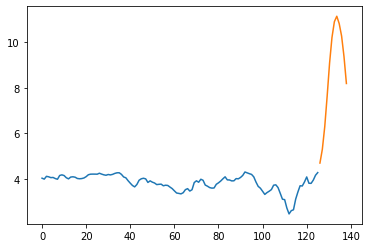

In [ ]:
#### Forecast ####

#from fractions import Fraction


from numpy import linspace


yarray=df_corr.to_numpy()
#print(y)
y=yarray[119:,:]
print(y)
print(y.size)
ResSVAR.exog = None
ResSVAR.coefs_exog = np.array(0)
ResSVAR.trend = "n"

steps = 12
ForecastSVAR = ResSVAR.forecast(y,steps)

print(ForecastSVAR)
ForecastPriceGas = ForecastSVAR[:,6]

serie=yarray[:,6]
print(serie.size)
length=serie.size
xserie = np.linspace(0,length-1,length)
xforecast = np.linspace(length,length+steps,steps)

print(xserie.size)
print(xforecast.size)


print()
plt.plot(xserie,serie)
plt.plot(xforecast,ForecastPriceGas)
plt.show()


138
[ 61.1756115   65.19834071  69.1797685   73.28323079  77.3668935
  81.41383028  85.46823629  89.4742786   93.45061456  97.59244974
 101.76166616 105.90019433 109.94281944 113.93597467 118.0080087
 122.09195852 126.15780072 130.16754207 134.16490362 138.17065705
 142.20267128 146.29274004 150.46705373 154.66652242 158.86861465
 163.07023607 167.26843001 171.50913066 175.71230245 179.88328594
 184.0349477  188.21957666 192.38665054 196.5775527  200.81083971
 205.07042964 209.3312567  213.52182012 217.59887439 221.63813402
 225.55053791 229.35376014 233.05456817 236.69425738 240.43966343
 244.37164057 248.36806067 252.38769964 256.37943243 260.21480064
 264.1197386  267.9680373  271.77927134 275.52043823 279.27344419
 283.03377436 286.72190354 290.43475472 294.13744742 297.76907602
 301.33387281 304.79965559 308.17029557 311.52300274 314.85532629
 318.23787467 321.75554784 325.31737824 328.77343429 332.28786566
 336.11705556 340.02437662 343.86800861 347.8442178  351.77422806
 355.494

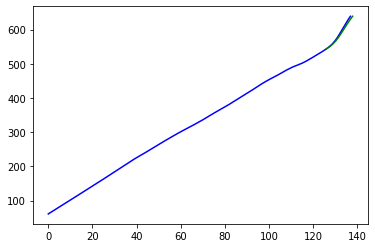

In [ ]:
#### DIFF INV ####
diff_total = np.concatenate((yarray[:,6], ForecastPriceGas), axis=0)
#print(yarray[:,4])
#print(set_total)

length_set = yarray[:,6].size + steps
print(length_set)
PriceReal = np.linspace(0,length_set,length_set)
PriceReal[0] = dprice_gas.values[0]

for i in range(1,length_set):
    PriceReal[i] = diff_total[i-1] + PriceReal[i-1]

print(PriceReal)
forecasted = PriceReal[-steps:]
print(forecasted)
print(PriceReal.size)

plt.plot(PriceReal, color='blue')
plt.plot(xforecast,forecasted,color="green")
plt.show()


(array([[-1.84777352e+01,  3.85562876e+00,  4.52713017e+00,
        -2.38187094e+00,  2.93228022e+02,  5.89982377e+00,
         4.68893121e+00],
       [-1.90308902e+01,  4.07487396e+00,  4.26432853e+00,
        -3.55458471e-01,  3.79928464e+02,  6.45827699e+00,
         5.29716855e+00],
       [-2.38708824e+01,  4.93469176e+00,  4.01047413e+00,
        -1.23961370e+00,  4.39584118e+02,  7.13057393e+00,
         6.29290736e+00],
       [-2.10468593e+01,  5.52726087e+00,  3.79161592e+00,
        -2.55186989e+00,  3.99538973e+02,  6.68807272e+00,
         7.63563219e+00],
       [-1.45051849e+01,  5.56014926e+00,  3.53808462e+00,
        -3.03126522e+00,  2.72100926e+02,  6.04803326e+00,
         9.08250351e+00],
       [-1.12629917e+01,  5.72651648e+00,  3.29248957e+00,
        -3.86025606e+00,  2.03577865e+02,  5.03159929e+00,
         1.02158745e+01],
       [-6.46170086e+00,  5.96197950e+00,  2.93316147e+00,
        -1.70434627e+00,  4.26300372e+01,  4.79609280e+00,
         1.091246

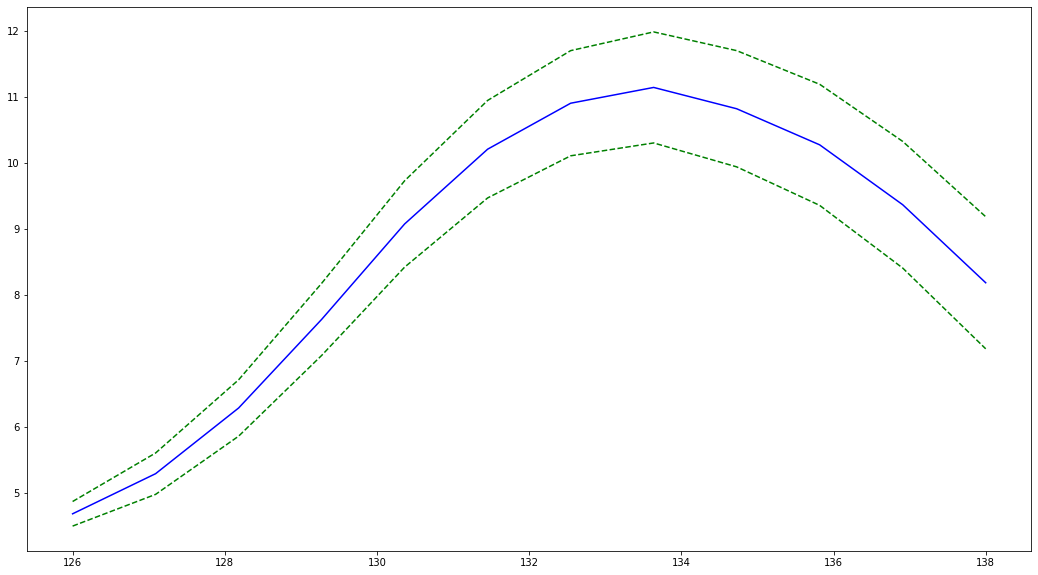

[ 64.14726783  69.13077398  74.99649115  82.08546815  90.51327319
  99.99020728 110.10557848 120.41581803 130.3636407  139.72760678
 148.1418673  155.3320449 ]


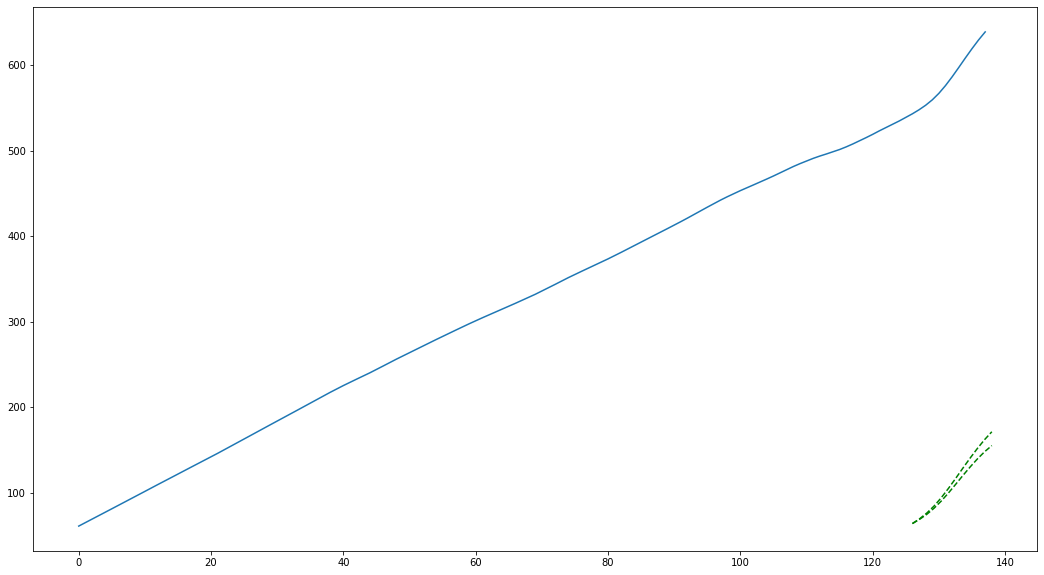

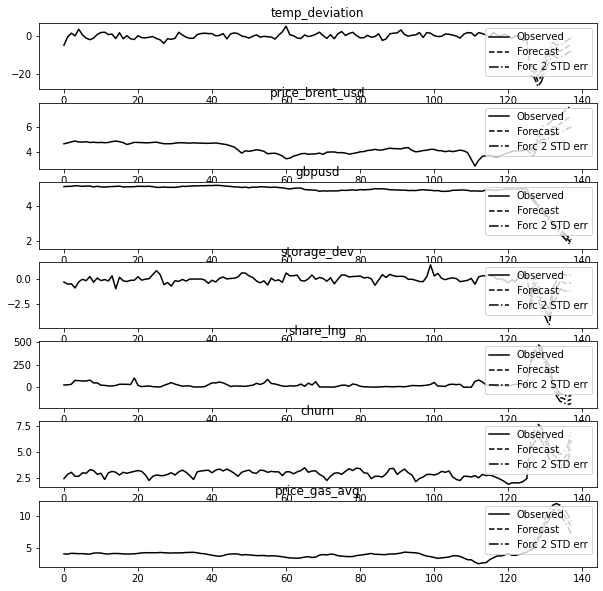

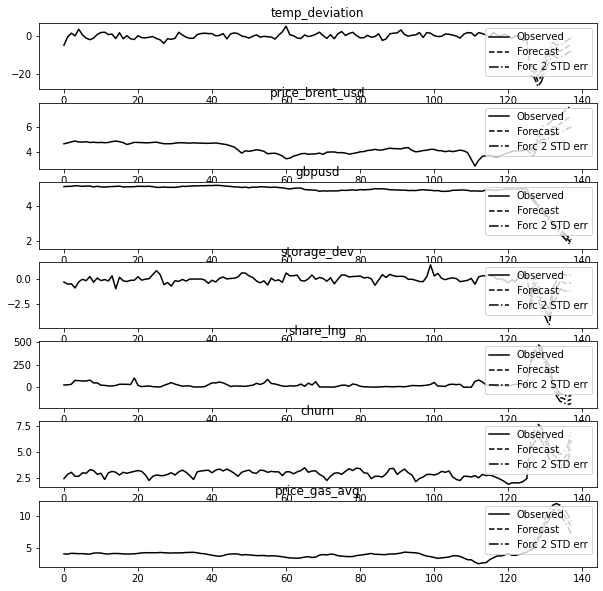

In [ ]:
ForecastIntSVAR = ResSVAR.forecast_interval(y,steps)
print(ForecastIntSVAR)

# differenciated
UpBandDiff = ForecastIntSVAR[2][:,6]
LowBandDiff = ForecastIntSVAR[1][:,6]
MidDiff = ForecastIntSVAR[0][:,6]

plt.figure(figsize=(18, 10))
plt.plot(xforecast,UpBandDiff, color ="green",linestyle='dashed')
plt.plot(xforecast,LowBandDiff, color="green",linestyle='dashed')
plt.plot(xforecast,MidDiff,color="blue")
plt.show()


# integrated
last_val = dprice_gas.values[-1]

UpBand = UpBandDiff
LowBand = LowBandDiff 

UpBand[0] = last_val
LowBand[0] = last_val

for i in range(1,steps):
    UpBand[i] = UpBand[i-1] + UpBandDiff[i]
    LowBand[i] = LowBand[i-1] + LowBandDiff[i]

print(LowBand)
xforecast = np.linspace(length,length+steps,steps)

plt.figure(figsize=(18, 10))
plt.plot(xforecast,UpBand, color ="green",linestyle='dashed')
plt.plot(xforecast,LowBand, color ="green",linestyle='dashed')
plt.plot(PriceReal)
plt.show()

ResSVAR.plot_forecast(steps)

#ResSVAR.plotsim()

In [ ]:
long_run = ResSVAR.test_inst_causality("lng")
long_run.summary()

ValueError: 'lng' is not in list

(array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+0

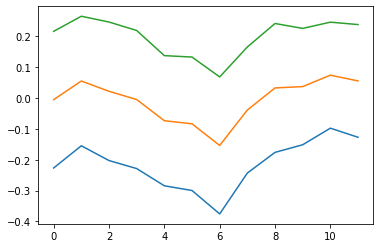

12
12
[ 64.14726783  69.43464002  76.36921378  84.87783213  95.07145126
 106.70571368 119.52365702 132.88796357 146.0589643  158.56872214
 170.28302171 180.93262773]
64.14726783468105
[5.287372187985065, 6.934573755447, 8.508618349362491, 10.193619128735666, 11.634262419432602, 12.817943346334879, 13.364306547894955, 13.171000730858049, 12.509757837653389, 11.714299572351814, 10.6496060179374, 9.220331595159761]
12


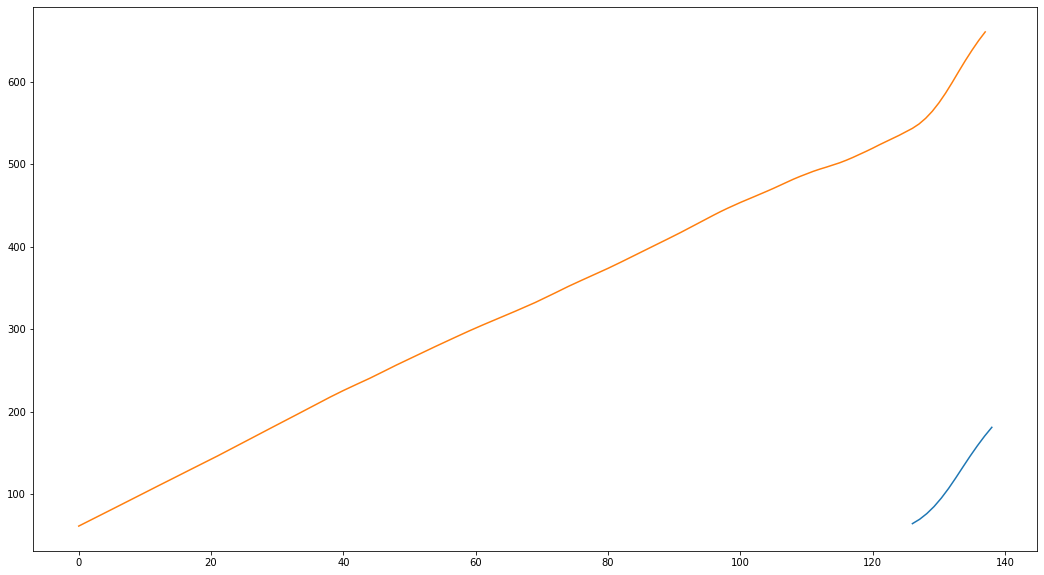

In [ ]:
#### SCENARIOS FORECAST ####

ResimBand = ResSVAR.irf_errband_mc(steps=steps,cum=False) #Tuple of lower and upper arrays of ma_rep monte carlo standard errors
Resim = ResSVAR.irf_resim()
print(ResimBand)

print(ResimBand[0])
UpperBand = []
LowerBand = []
Mid = []

for i in range(1,steps+1):
    UpperBand.append(ResimBand[0][i][3][4])
    LowerBand.append(ResimBand[1][i][3][4])



print("---------------------------")
print(UpperBand)

print("---------------------------")
print(LowerBand)


for i in range(0, steps):
    Mid.append((UpperBand[i] + LowerBand[i])/2)


plt.plot(UpperBand)
plt.plot(Mid)
plt.plot(LowerBand)
plt.show()

###########################

MidDiffTot = []
diff_forecast = diff_total[-steps:]
print(len(diff_forecast))
print(len(Mid))
for i in range(0,len(Mid)):
    MidDiffTot.append(Mid[i] + diff_forecast[i])

MidImp = np.linspace(0,steps,steps)
MidImp[0] = last_val

for i in range(1,steps):
    MidImp[i] = MidImp[i-1] + MidDiffTot[i-1]

print(MidImp)
print(last_val)
print(MidDiffTot)
print(len(MidImp))
plt.figure(figsize=(18, 10))
plt.plot(xforecast,MidImp)
plt.plot(PriceReal)
plt.show()

In [1]:
ResSVAR.exog = None
ResSVAR.coefs_exog = np.array(0)
ResSVAR.trend = "n"


df_forecast=df_corr.loc[150:,:]
yarray=df_forecast.to_numpy()

steps = 3
ForecastSVAR = ResSVAR.forecast(yarray,steps)
ForecastPriceGas = ForecastSVAR[:,6]

serie=yarray[:,6]
print(serie.size)
length=serie.size
xserie = np.linspace(0,length-1,length)
xforecast = np.linspace(length,length+steps,steps)

print(xserie.size)
print(xforecast.size)

print()
plt.plot(xserie,serie)
plt.plot(xforecast,ForecastPriceGas)
plt.show()

NameError: name 'ResSVAR' is not defined

In [ ]:
#### DIFF INV ####
total = np.concatenate((yarray[:,6], ForecastPriceGas), axis=0)
#print(yarray[:,4])
#print(set_total)

length_set = yarray[:,6].size + steps

plt.plot(total, color='blue')
plt.plot(xforecast,ForecastPriceGas,color="green")
plt.show()

In [ ]:
ForecastIntSVAR = ResSVAR.forecast_interval(y,steps)
print(ForecastIntSVAR)


# differenciated
UpBand = ForecastIntSVAR[2][:,6]
LowBand = ForecastIntSVAR[1][:,6]
Mid = ForecastIntSVAR[0][:,6]

plt.figure(figsize=(18, 10))
plt.plot(xforecast,UpBand, color ="green",linestyle='dashed')
plt.plot(xforecast,LowBand, color="green",linestyle='dashed')
plt.plot(xforecast,Mid,color="blue")
plt.show()

